## 익스

이번 익스는 의료영상을 가지고 분석하는 것입니다. 그렇기 때문에 원하는 데이터셋이 부족할 것이라고 생각하여 augmentation기법 사용을 잘해야할 것 같습니다.


## 루브릭

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.

모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.



2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.



3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

Accuracy 기준 85%에 도달하였다.

# Step 1. 실험환경 Set-up

In [1]:
# 필요라이브러리 호출

import os
import re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# Step2. 데이터 가져오기

In [3]:


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# val가 너무 적기에 train과 val를 합친 후 8:2로 나누기
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:

# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person9_bacteria_39.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person337_bacteria_1566.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


In [7]:
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:


# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:


# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 만들기

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 리사이즈 확인과 라벨에 잘 들어갔는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### 간단한 augmentation 이용

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step3. 데이터 시각화



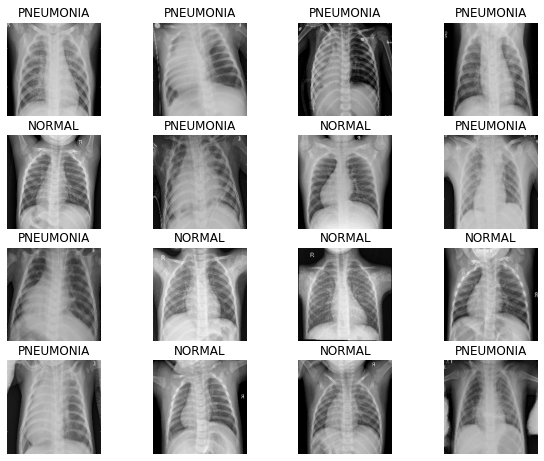

In [15]:
# 첫 배치 추출한 후에 image와 label 데이터 셋으로 나눈다
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

조금씩 기울어진 것으로 보아 어느정도는 aumentation의 좌우반전이 잘 된 것 같습니다.

# Step 4. CNN 모델링

### Normalization

순서:

Convolution block을 만듭니다.

conv_block()의 구성은 Convolution두 번 진행--> Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 
그리고 Max Pooling을 합니다.

In [16]:
def conv_block_batch(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:

def dense_block_batch(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [18]:
def build_model_batch():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_batch(32),
        conv_block_batch(64),
        
        conv_block_batch(128),
        
        conv_block_batch(256),
        
        tf.keras.layers.Flatten(),
        dense_block_batch(512, 0.7),
        dense_block_batch(128, 0.5),
        dense_block_batch(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Dropout

In [19]:

def conv_block_do(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block_do(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model_do():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_do(32),
        conv_block_do(64),
        
        conv_block_do(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_do(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_do(512, 0.7),
        dense_block_do(128, 0.5),
        dense_block_do(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

###  normalization , dropout, augmentation

In [22]:

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

In [25]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


# Step 6. 모델훈련

### Normalization

In [26]:
with tf.device('/GPU:0'):
    model = build_model_batch()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 102s 233ms/step - loss: 0.3398 - accuracy: 0.8499 - precision: 0.9581 - recall: 0.8310 - val_loss: 0.7022 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 223ms/step - loss: 0.1830 - accuracy: 0.9296 - precision: 0.9769 - recall: 0.9275 - val_loss: 1.2148 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 226ms/step - loss: 0.1616 - accuracy: 0.9387 - precision: 0.9792 - recall: 0.9388 - val_loss: 0.2417 - val_accuracy: 0.8904 - val_precision: 0.8723 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1348 - accuracy: 0.9456 - precision: 0.9870 - recall: 0.9400 - val_loss: 0.1841 - val_accuracy: 0.9183 - val_precision: 0.9038 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1380 - accur

### Dropout

In [28]:

with tf.device('/GPU:0'):
    model2 = build_model_do()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 69s 224ms/step - loss: 0.4989 - accuracy: 0.7773 - precision: 0.8561 - recall: 0.8531 - val_loss: 0.5717 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 223ms/step - loss: 0.2447 - accuracy: 0.8925 - precision: 0.9762 - recall: 0.8760 - val_loss: 2.0432 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 223ms/step - loss: 0.1903 - accuracy: 0.9277 - precision: 0.9825 - recall: 0.9191 - val_loss: 0.1433 - val_accuracy: 0.9538 - val_precision: 0.9560 - val_recall: 0.9832
Epoch 4/25
261/261 [==============================] - 58s 224ms/step - loss: 0.1357 - accuracy: 0.9473 - precision: 0.9885 - recall: 0.9398 - val_loss: 0.1239 - val_accuracy: 0.9596 - val_precision: 0.9791 - val_recall: 0.9664
Epoch 5/25
261/261 [==============================] - 59s 226ms/step - loss: 0.1537 - accura

###  normalization , dropout, augmentation

In [30]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 71s 227ms/step - loss: 0.5345 - accuracy: 0.7295 - precision: 0.9210 - recall: 0.6929 - val_loss: 0.6205 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.2626 - accuracy: 0.8963 - precision: 0.9726 - recall: 0.8863 - val_loss: 1.2956 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 226ms/step - loss: 0.2111 - accuracy: 0.9130 - precision: 0.9770 - recall: 0.9052 - val_loss: 0.4832 - val_accuracy: 0.7519 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 58s 223ms/step - loss: 0.1858 - accuracy: 0.9316 - precision: 0.9799 - recall: 0.9280 - val_loss: 0.1074 - val_accuracy: 0.9663 - val_precision: 0.9868 - val_recall: 0.9677
Epoch 5/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1757 - accura

#### 하이퍼파라미터 조정

- 저희는 정확도 85%를 넘어야 합니다!

- Epochs, Batch_size 조정합니다.

In [32]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:

BATCH_SIZE = 40
EPOCHS = 35

In [44]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
104/104 [==============================] - 38s 277ms/step - loss: 0.1895 - accuracy: 0.9237 - precision: 0.9760 - recall: 0.9200 - val_loss: 0.0959 - val_accuracy: 0.9736 - val_precision: 0.9808 - val_recall: 0.9839
Epoch 2/35
104/104 [==============================] - 29s 283ms/step - loss: 0.1905 - accuracy: 0.9279 - precision: 0.9766 - recall: 0.9238 - val_loss: 0.0641 - val_accuracy: 0.9784 - val_precision: 0.9864 - val_recall: 0.9831
Epoch 3/35
104/104 [==============================] - 30s 286ms/step - loss: 0.1515 - accuracy: 0.9381 - precision: 0.9806 - recall: 0.9357 - val_loss: 0.3435 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8442
Epoch 4/35
104/104 [==============================] - 31s 300ms/step - loss: 0.1658 - accuracy: 0.9375 - precision: 0.9833 - recall: 0.9333 - val_loss: 2.6922 - val_accuracy: 0.3654 - val_precision: 1.0000 - val_recall: 0.1287
Epoch 5/35
104/104 [==============================] - 30s 294ms/step - loss: 0.1808 - accura

# Step 7. 시각화 및 결과 확인

### Normalization



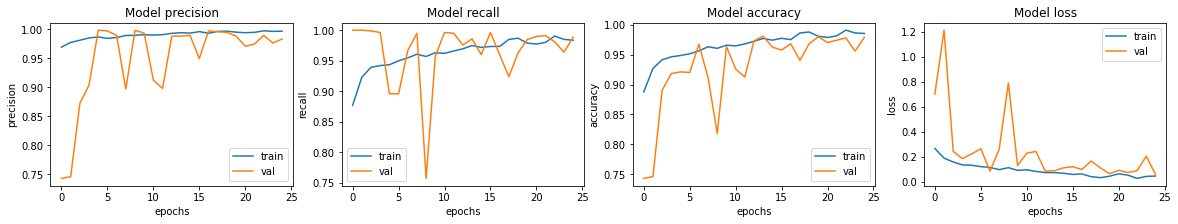

In [45]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
# 결과 확인
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.8882 - accuracy: 0.7708 - precision: 0.7361 - recall: 0.9872
Loss: 0.8881708979606628,
Accuracy: 0.7708333134651184,
Precision: 0.7361376881599426,
Recall: 0.9871794581413269


### Dropout

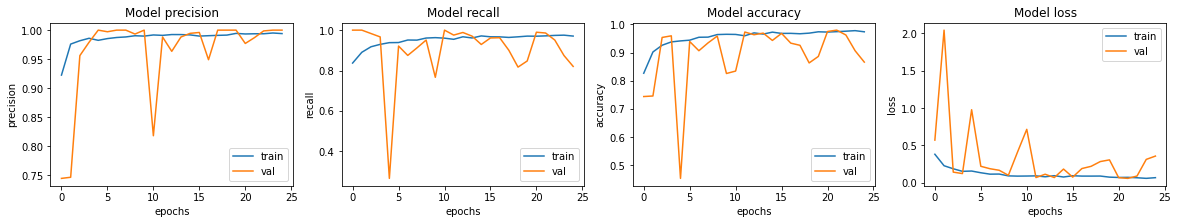

In [47]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
# 결과 확인
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 148ms/step - loss: 0.4547 - accuracy: 0.8670 - precision: 0.8946 - recall: 0.8923
Loss: 0.4547051787376404,
Accuracy: 0.8669871687889099,
Precision: 0.8946015238761902,
Recall: 0.892307698726654


###  normalization , dropout, augmentation

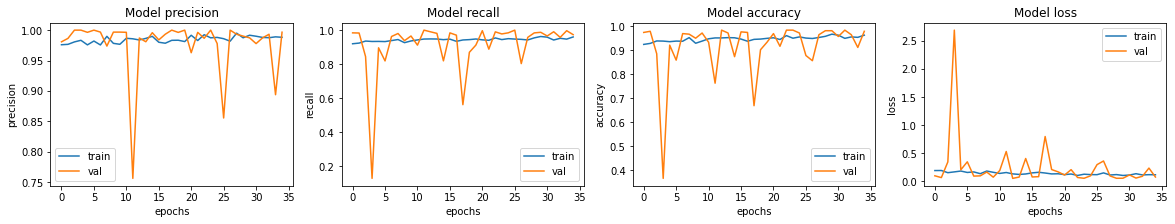

In [49]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
# 결과 확인
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.4323 - accuracy: 0.8814 - precision: 0.8575 - recall: 0.9718
Loss: 0.4322916269302368,
Accuracy: 0.8814102411270142,
Precision: 0.8574660420417786,
Recall: 0.971794843673706


###  하이퍼파라미터 조정

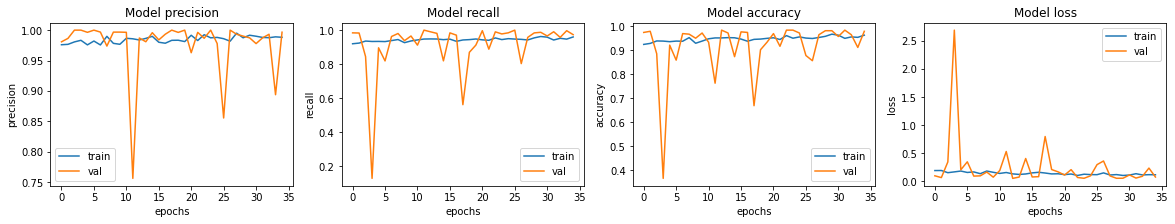

In [51]:
# 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
# 결과 확인
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.4323 - accuracy: 0.8814 - precision: 0.8575 - recall: 0.9718
Loss: 0.432291716337204,
Accuracy: 0.8814102411270142,
Precision: 0.8574660420417786,
Recall: 0.971794843673706


# 회고


## 실험 결과

1. Normalization

- (Batch_size=16, Epochs=25)

- Accuracy: 77%, Recall: 98%

2. Dropout

- (Batch_size=16, Epochs=25)

- Accuracy: 86%, Recall: 89%

3. normalization , dropout, augmentation

- (Batch_size=16, Epochs=25)

- Accuracy: 88%, Recall: 97%

4. Hyperparameter 조정

- (Batch_size=30, Epochs=35)

- Accuraacy: 85%, Recall: 97%

처음에 그대로 Batch_size=16, Epochs=25를 했을 때에는 Accuracy = 76% , Recall: 86%로 너무나 낮았습니다.

그래서 좀 빠른 학습을 하고 싶어서 Batch_size를 2배 정도 늘리고 Epochs 5씩 늘려서 Batch_size = 30, Epochs=30으로 했을 때는 Accuracy = 84.9%, Recall = 95%로 거의 근접했습니다. 

그리고 Epochs를 5만 늘리면 될 것 같아서

Batch_Size=30, Epochs=35로 했더니 Accuracy=85%, Recall=97%가 나왔습니다


## 느낀점

- 일전에 했던 유방암 데이터 셋으로 했던 프로젝트에서는 Recall값이 중요하다고 생각하여 억지로 Recall값이 증가할 때까지 해봤으나 정확도가 65%까지 떨어졌습니다. 그래서 그냥 정확도만 85% 늘리기 위해 하이퍼파라미터 조정을 하거나 가우시안 이용을 잠깐 한 것 같습니다.